In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Measuring Literature project

In [67]:
df = pd.read_excel("poems.xlsx", names=["Poet", "Poem", "Hemistich", "Verse","Text", "?"], index_col=0)
df.index.name="Index"
df.Text = df.Text.str.strip()
df.drop([333186], inplace=True)
df.head(10)

,Poet,Poem,Hemistich,Verse,Text,?
Index,,,,,,
1,1,1,1,1,الا یا ایها الساقی ادر کاسا و ناولها,0
2,1,1,2,1,که عشق آسان نمود اول ولی افتاد مشکل‌ها,0
3,1,1,3,2,به بوی نافه‌ای کاخر صبا زان طره بگشاید,0
4,1,1,4,2,ز تاب جعد مشکینش چه خون افتاد در دل‌ها,0
5,1,1,5,3,مرا در منزل جانان چه امن عیش چون هر دم,0
6,1,1,6,3,جرس فریاد می‌دارد که بربندید محمل‌ها,0
7,1,1,7,4,به می سجاده رنگین کن گرت پیر مغان گوید,0
8,1,1,8,4,که سالک بی‌خبر نبود ز راه و رسم منزل‌ها,0
9,1,1,9,5,شب تاریک و بیم موج و گردابی چنین هایل,0


## Mapping the poets' id to names

In [70]:
poet={1:"Hafez", 2:"Saadi", 3:"Molavi", 4:"Attar", 5:"Sanaee", 6:"Vahshi", 7:"Khaghani", 8:"Anvari", 9:"Ouhadi", 10:"Khajoo",
      11:"Eraghi", 12:"Bahar", 13:"Hatef", 14:"Saeb Tabrizi", 15:"Kashani", 16:"Amir Khosro", 17:"Bahaee", 18:"Shahriar",
      19:"Shah Nematollah", 20:"Seyf Farghani", 21:"Salman", 22:"Ghaani", 23:"Orfi", 24:"Obeyd", 25:"Helali",
      26:"Forooghi", 27:"Feyz", 28:"Bidel", 29:"Razi", 30:"Rahi"}

# Exploratory analysis

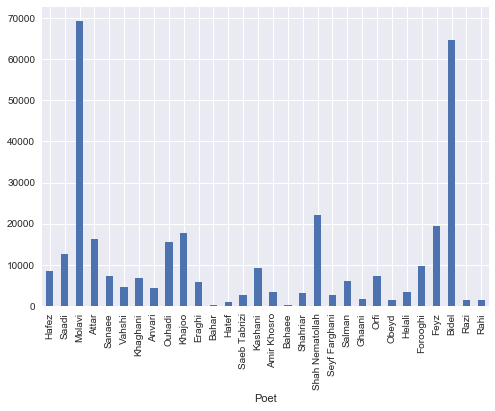

In [82]:
#Distribution of poems by poet
df_count_hemi = df[["Poet"]].groupby("Poet").size()
ax = df_count_hemi.plot("bar")
ax.set_xticklabels(list(poet.values()));